# Advanced Time-Series Analysis and Deep Learning: Homework #3

## Ensuring Result Reproducability

In [700]:
#Import numpy
import numpy as np
import torch

### Set a random seed so I can reproduce results
seed = 40
np.random.seed(seed)
torch.manual_seed(seed)

## Motif Discovery [30 points]

### 1. Mathematical Formulation [10 points]:

Define what a motif is in time-series data. [3 points]

Reference [1]

(a): In time-series data, motifs are pairs of individual time series, or subsequences of longer time series, which are very similar to each other. A motif can tell us about recurring patterns within time series data!

Mathematically formulate the problem of motif discovery. Include any assumptions and notations. [7 points]

Reference [1]

(b): 
Let me formulate this mathematically. 

<ins> Case 1: Time Series Motif </ins>

I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

A Time Series Database $D$ is an unordered set of m time series possibly of different lengths.

The Time Series Motif of $D$ is the unordered pair of time series ${T_i, T_j}$ in D which is the most similar among all possible pairs

Essentially, $\forall a,b,i,j$, 

${T_i, T_j}$ is the motif iff $dist(T_i, T_j) ≤ dist(T_a, T_b)$, $i \neq j$ and $a \neq b$.


<ins> Case 2: Subsequence Motif </ins>

We can also calculate a Subsequence Motif. Given a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

Let's say we have two subsequences $T_c$ and $T_d$

Essentially, $\forall c,d,i,j$, 

${T_c, T_d}$ is the subsequence motif iff $dist(T_c, T_d) ≤ dist(T_i, T_j)$, $i \neq j$ and $c \neq d$.



### 2. Synthetic Dataset Generation [5 points]:

Generate a synthetic time-series dataset that includes at least one embedded motif. [5 points]

In [701]:
#Import Libraries
import matplotlib.pyplot as plt

#Generate Synthetic Data
#base_amplitude: amplitude of base time series
#motif_amplitude: amplitude of embedded motif
#periods: number of periods in base time series wave
#points: number of points to include in base time series wave
#motif_points: number of points to include in motif wave
def generateSyntheticData(base_amplitude, motif_amplitude, periods, points, motif_points):
    #Generate time frame
    base_t = np.linspace(0, periods, points)
    
    #Generate base time series
    base_time_series = base_amplitude * np.sin(2 * np.pi * base_t) + np.random.normal(loc = 0.0, scale = 0.9, size = (len(base_t),))
    
    #Plot Base Time Series
    plt.figure()
    plt.plot(base_t, base_time_series)
    plt.title("Base Time Series")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.show()
    
    #Generate Motif
    motif_t = np.linspace(0, 1, motif_points)
    motif_time_series = motif_amplitude * np.cos(2 * np.pi * motif_t)
    
    #Plot Motif Time Series
    plt.figure()
    plt.plot(motif_t, motif_time_series)
    plt.title("Motif Time Series")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.show()
    
    #Embed Motif within Base Time Series
    num_motif_injections = 4
    motif_injections = [] #Previous Motif Injections
    
    #Inject Motifs within Time Series
    for _ in range(num_motif_injections):
        while True:
            pivot = np.random.randint(low = 0, high = points - motif_points)
                                    
            #We need to determine if this injection is valid
            valid_injection = any(
                (not (motif_injection[1] < pivot or pivot + motif_points < motif_injection[0])) or 
                (abs(motif_injection[1] - pivot) < 0.5 * motif_points or abs(motif_injection[0] - pivot + motif_points) < 0.5 * motif_points)
                for motif_injection in motif_injections
            )
            
            if not valid_injection: break

        #Put the motif in the numpy array for the base time series
        base_time_series[pivot: pivot + motif_points] = motif_time_series
        motif_injections.append((pivot, pivot + motif_points))
    
    #Environmental Noise
    noise = np.random.normal(loc = 0, scale = 0.15, size = (points,))
    
    #Plot Noise Time Series
    plt.figure()
    plt.plot(base_t, noise)
    plt.title("Noise")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.show()
    
    #Plot Base Time Series with Injected Motif
    plt.figure()
    plt.plot(base_t, base_time_series)
    plt.title("Base Time Series with Injected Motif")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.show()
    
    #Plot Base Time Series with Injected Motif and Environmental Noise
    plt.figure()
    plt.plot(base_t, base_time_series + noise)
    plt.title("Base Time Series with Injected Motif and Environmental Noise")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.show()
    
    #Return adjusted base time series(with embedded motif and environmental noise) and the motif time series
    adjusted_base_time_series = base_time_series + noise
    return adjusted_base_time_series, motif_time_series

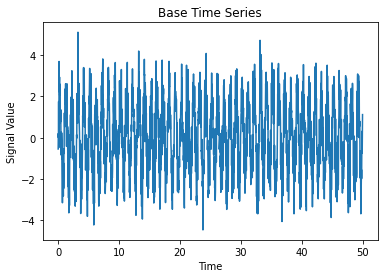

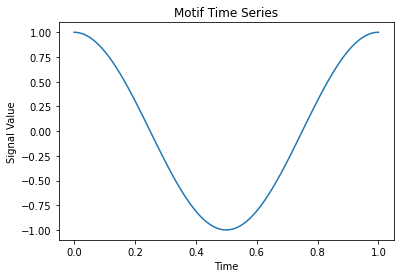

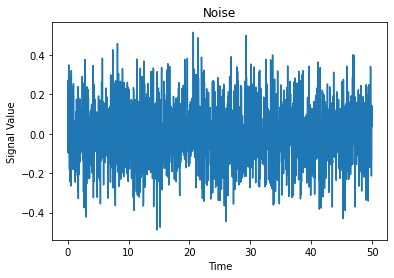

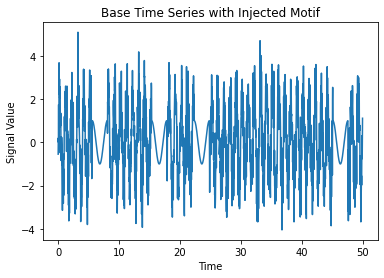

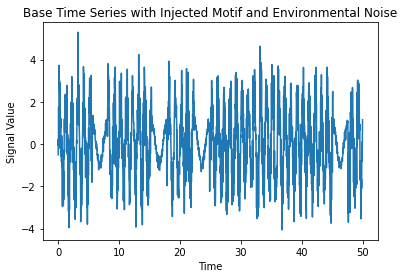

In [702]:
x_adjusted, motif_time_series = generateSyntheticData(2, 1, 50, 2000, 100)

To generate a synthetic time-series dataset that includes at least one embedded motif, here are the steps I followed: 
1. To generate a base time series, I just made a sine wave
2. To embed a motif, I injected a repeating pattern at random intervals in this time series.
3. Finally, to obscure the motif a bit, I added some random noise

## Matrix Profile [30 points]

Define the concept of matrix profile in time-series analysis and derive its mathe- matical formulation. [10 points]

Reference [2]

General Concept: 
In time series analysis, a matrix profile is used to find anomalies and trends within time series data. 

For each subsequence of the time series, the naive matrix profile algorithm first computes a distance profile for that subsequence. Then, the matrix profile takes the minimum of that distance profile to get a singular value for this subsequence. This process is repeated for all such subsequences of the time series to obtain a matrix profile 

The subsequences of the time series can be defined as members of a set A where A is an ordered set of all possible subsequences of T(the original time series) obtained by sliding a window of length m across T

The smallest entries in the matrix profile would give us insight into the motifs. On the other hand, the largest values in the matrix profile would give us insight into the discords of the time series. 

Mathematical Formulation: 

1. I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

2. A subsequence $T_{i,m}$ of a T is a continuous subset of the values from T of length m starting from position i. $T_{i,m} = t_i, t_{i+1} ,…, t_{i+m-1}$, where $1 \leq i \leq n-m+1$.

3. A distance profile D is a vector of the Euclidean distances between a given query and each subsequence in an all-subsequences set

4. An all-subsequences set A of a time series T is an ordered set of all possible subsequences of T obtained by sliding a window of length m across T: 

$A ={T_{1,m},, T_{2,m},…, T_{n-m+1,m}}$, where m is a user-defined subsequence length. We use A[i] to denote $T_{i,m}$.

5. 1NN-join function: given two all-subsequences sets A and B and two subsequences A[i] and B[j], a 1NN-join function $\theta_{1nn}$ (A[i], B[j]) is a Boolean
function which returns “true” only if B[j] is the nearest neighbor of A[i] in the set B.

6. Similarity join set: given all-subsequences sets A and B, a similarity join set $J_{AB}$ of A and B is a set containing pairs of each subsequence in A with its nearest neighbor in B: $J_{AB}={〈 A[i], B[j] 〉| θ_{1nn} (A[i], B[j])}$ . We denote this formally as $J_{AB} = A \bowtie_{\theta_{1nn}} B$.

7. A matrix profile (or just profile) $P_{AB}$ is a vector of the Euclidean distances between each pair in $J_{AB}$

### 3. Algorithm Implementation [15 points]:

In [703]:
#T: Time Series
#M: Size of Sliding Window
def generate_subsequences_set(T, M):
    N = len(T) - M + 1 #Number of subsequences
    indices = np.arange(M) + np.arange(N)[:, np.newaxis]
    return T[indices]

As I explained above in the mathematical formulation, A is an all-subsequences set of T. Essentially, A represents an ordered set of all possible subsequences of T obtained by sliding a window of length m across T. 

Given a time series T and a window length M, this function(generate_subsquences_set) creates a list of all contiguous subsequences of length M from the Time Series T. Essentially, this function(generate_subsequences_set) generates "A". 

In [704]:
# A: List of contiguous subsequences of length M from the Time Series T
def generate_matrix_profile(A):
    N, M = A.shape[0], A.shape[1] #N: Number of subsequences, M: Length of each subsequence
    
    
    exclusion = np.ceil(M / 2)
    distances = np.zeros(shape = (N,))
    indices = np.zeros(shape = (N,))
    
    #For each query subsequence, do the following iteration
    for i in range(N):
        #Exclusion Zone(Refer to Markdown Below for Explanation)
        bound1 = max(0, i - exclusion)
        bound2 = min(i + exclusion, N - 1)
        
        #Compute minimum distance to other subsequences
        min_distance = float('inf')
        min_index = None
        for j in range(N):
            if bound1 <= j and j <= bound2: continue 
            d = np.linalg.norm(A[i] - A[j])
            if d < min_distance:
                min_distance = d
                min_index = j
        
        distances[i] = min_distance
        indices[i] = min_index
    
    return distances, indices

Note[2]: The distance profile must be zero at the location of the query, and close to zero just before and just after. Such matches are called trivial matches in the literature and are avoided by ignoring an exclusion zone of m/2 before and after the location of the query.

The input to the function generate_matrix_profile is "A", which represents the list of all contiguous subseequences of length M from the time series T. This function returns two arrays, "distances" and "indices". Let the length of "A" be N. For each index i where 0 $\leq$ i $\leq$ N - 1, distances[i] represents the distance between A[i] and its nearest neighbor and indices[i] = j such that A[j] is the nearest neighbor of A[i]. 

### (a) Apply your matrix profile algorithm using a sliding window approach to find motifs in your synthetic dataset. [7 points]

In [705]:
T = x_adjusted
M = 100
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)

#To find a motif, we need to find a minimum value in the matrix profile 
ix = np.where(distance_profile == np.min(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

In [706]:
#Print Statement for Sanity
print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[ 224 1804]
[1804.  224.]
[1.98418224 1.98418224]


Text(0, 0.5, 'Minimum Distance')

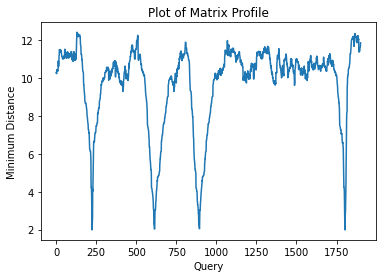

In [707]:
plt.title("Plot of Matrix Profile")
plt.plot(distance_profile)
plt.xlabel("Query")
plt.ylabel("Minimum Distance")

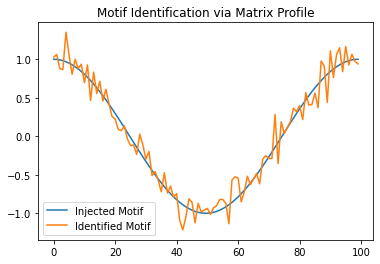

In [708]:
plt.title("Motif Identification via Matrix Profile")
plt.plot(motif_time_series, label = "Injected Motif")
plt.plot(A[ix[0]], label = "Identified Motif")
plt.legend()

As shown, our matrix profile algorithm is able to roughly recover the motif that we injected into our time series earlier!

### (b) Optimize your algorithm’s performance by incorporating techniques such as early abandoning or using efficient data structures like suffix trees or arrays. [3 points]

Reference [2]

In [709]:
### Optimize Matrix Profile Algorithm using FFT Approach outlined in paper

#Compute a sliding dot product between a Query Subsequence(Q) and a Time Series (T)
#Sliding Dot Product: Dot Products obtained by sliding a query subsequence across the time series(i.e. sort of like how we do in convolution)
def sliding_dot_product(Q, T):
    n, m = len(T), len(Q)
    Ta = np.append(T, np.zeros(n))
    Qr = np.flip(Q)
    Qra = np.append(Qr, np.zeros(2 * n - m))
    Qraf, Taf = np.fft.fft(Qra), np.fft.fft(Ta)
    QT = np.fft.ifft(Qraf * Taf)
    return QT

#Compute the Mean and Standard Deviations of the subsequences of T(Time Series).
#The subsequences are obtained via the sliding window approach
def compute_mean_std(Q, T):
    uq = np.mean(Q) #mean of Q
    stdev_Q = np.std(Q) #stdev of Q
    
    #initialize Mean and Stdev of T
    n,m = len(T), len(Q)
    M = np.zeros(shape = (n - m + 1,))
    Sigma = np.zeros(shape = (n - m + 1,))
    
    #Initialize Sliding Window
    window = T[0:m]
    
    #Compute initial Mean and Stdev of Sliding Window
    M[0] = np.mean(window)
    Sigma[0] = np.std(window)
    
    #Keep running total of the sum of the elements in the sliding window and sum of squares of elements of the sliding window
    total = np.sum(window)
    total_elements_squared = np.sum(window ** 2)
    
    #Keep track of the bounds of the sliding window
    window_start = 0
    window_end = m - 1
    
    #Iteratively move the sliding window across T and adjust mean and stdev
    for index in range(1, n - m + 1):
        #Update the unning total of the sum of the elements in the sliding window and sum of squares of elements of the sliding window
        total = total - T[window_start] + T[window_end + 1]
        total_elements_squared = total_elements_squared - (T[window_start] ** 2) + (T[window_end + 1] ** 2)
        
        #Solve for Mean and Std.Dev of the current sliding window of T
        M[index] = total / m
        Sigma[index] = np.sqrt((total_elements_squared - (2 * M[index] * total) + ((M[index] ** 2) * m)) / m)
        
        #adjust bounds of sliding window
        window_start += 1
        window_end += 1
    
    return uq, stdev_Q, M, Sigma

#Calculate Distance Profile for Query(Q), given a time series (T)
#QT: Sliding Dot Product
#uq: Mean of Q
#stdev_Q: standard deviation of Q
#MT: Mean of T
#SigmaT: St.Dev of T
def calculate_distance_profile(Q, T, QT, uq, stdev_Q, MT, SigmaT):
    n, m = len(T), len(Q)
    QT = QT[m - 1: n]
    D = np.sqrt(2 * m * (1 - ((QT - m * uq * MT) / (m * stdev_Q * SigmaT))))
    return D

#Return the distance profile for a Query(Q), given the original time series (T)
def MASS(Q, T):
    QT = sliding_dot_product(Q, T)
    uq, stdev_Q, MT, SigmaT = compute_mean_std(Q, T)
    D = calculate_distance_profile(Q, T, QT, uq, stdev_Q, MT, SigmaT)
    return D

#Compute Matrix Profile for the all-subsequence set of T(Time Series)
#A: All-Subsequence Set
def optimized_matrix_profile(A):
    N, M = A.shape[0], A.shape[1]
    
    #Exclusion Zone
    exclusion = np.ceil(M / 2)
    distance_profile = np.zeros(shape = (len(A),))
    index_profile = np.zeros(shape = (len(A),))
    
    #Iterate through each subsequence in A
    for index in range(len(A)):
        row = A[index]
        
        #Compute distance profile for the current subsequence
        distances = MASS(row, T)
        
        #Set up exclusion zone
        bound1 = max(0, index - exclusion)
        bound2 = min(index + exclusion, N - 1)
        distances[int(bound1): int(bound2) + 1] = np.inf
        
        #Calculate minimum distance
        distance_profile[index] = np.min(distances)
        index_profile[index] = np.argmin(distances)
    
    return distance_profile, index_profile

This is an implementation of the STAMP Algorithm[2]. This algorithm relies on FFT(Fast Fourier Transform) to compute Euclidean distances between a subsequence and subsequences in the original time sries. 

### (c) Test your algorithm on different synthetic datasets to validate its robustness and accuracy. [3 points]

In [710]:
A = generate_subsequences_set(T, M)
distance_profile, index_profile = optimized_matrix_profile(A)

#To find a motif, we need to find a minimum value in the Matrix profile 
ix = np.where(distance_profile == np.min(distance_profile))[0]

index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_75683/1390546214.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  distance_profile[index] = np.min(distances)


In [711]:
print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[613]
[1803.]
[2.69502805]


Text(0, 0.5, 'Minimum Distance')

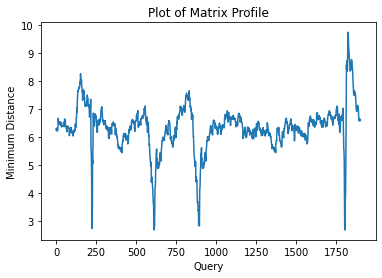

In [712]:
plt.title("Plot of Matrix Profile")
plt.plot(distance_profile)
plt.xlabel("Query")
plt.ylabel("Minimum Distance")

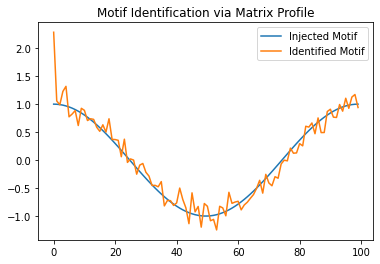

In [713]:
plt.title("Motif Identification via Matrix Profile")
plt.plot(motif_time_series, label = "Injected Motif")
plt.plot(A[ix[0]], label = "Identified Motif")
plt.legend()

As shown, our optimized matrix profile algorithm is able to identify the motif!

### Testing Optimized Matrix Profile Algorithm Implementation On Other Synthetic Data

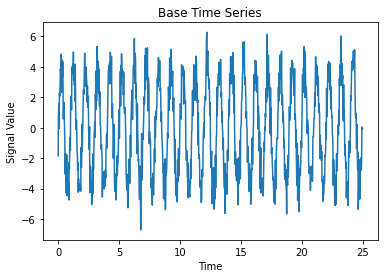

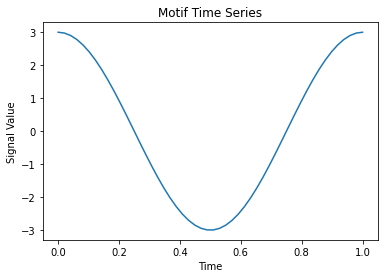

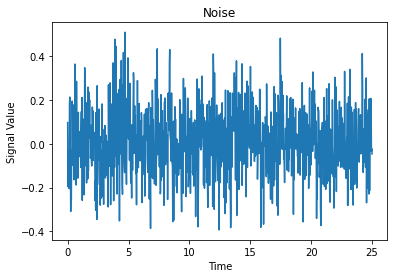

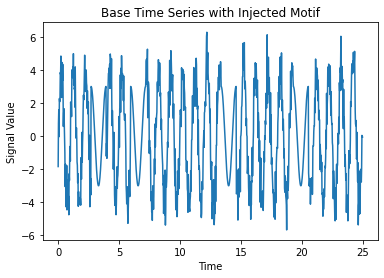

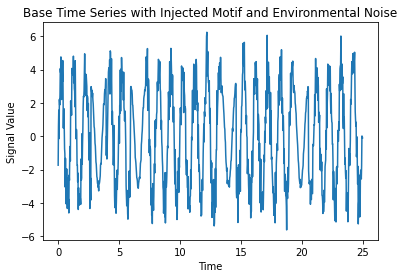

/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_75683/1390546214.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  distance_profile[index] = np.min(distances)


In [714]:
#Generate Synthetic Data
x_adjusted_optimized, motif_time_series_optimized = generateSyntheticData(4, 3, 25, 1000, 50)

#Optimized T, Optimized M
T_optimized = x_adjusted_optimized
M_optimized = 50

#Generate subsequences
A_optimized = generate_subsequences_set(T_optimized, M_optimized)
distance_profile_optimized, index_profile_optimized = optimized_matrix_profile(A_optimized)

#To find a motif, we need to find a minimum value in the Matrix Profile 
ix_optimized = np.where(distance_profile_optimized == np.min(distance_profile_optimized))[0]
index_profile_ix_optimized = index_profile_optimized[ix_optimized]
distance_profile_ix_optimized = distance_profile_optimized[ix_optimized]

In [715]:
print(ix_optimized)
print(index_profile_ix_optimized)
print(distance_profile_ix_optimized)

[244]
[925.]
[2.4506508]


Text(0, 0.5, 'Minimum Distance')

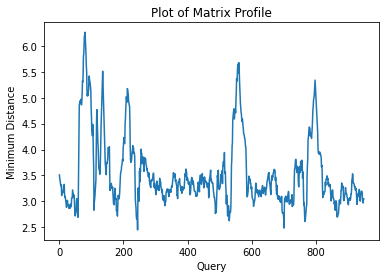

In [716]:
plt.title("Plot of Matrix Profile")
plt.plot(distance_profile_optimized)
plt.xlabel("Query")
plt.ylabel("Minimum Distance")

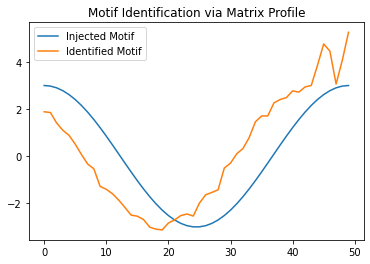

In [717]:
plt.title("Motif Identification via Matrix Profile")
plt.plot(motif_time_series_optimized, label = "Injected Motif")
plt.plot(A_optimized[ix_optimized[0]], label = "Identified Motif")
plt.legend()

As shown, our optimized matrix profile algorithm is able to identify the rough shape of the motif still!

In [718]:
A_optimized = generate_subsequences_set(T_optimized, M_optimized)
distance_profile_optimized, index_profile_optimized = generate_matrix_profile(A_optimized)

#To find a motif, we need to find a minimum value in the Matrix profile 
ix_optimized = np.where(distance_profile_optimized == np.min(distance_profile_optimized))[0]

index_profile_ix_optimized = index_profile_optimized[ix_optimized]
distance_profile_ix_optimized = distance_profile_optimized[ix_optimized]

Text(0, 0.5, 'Minimum Distance')

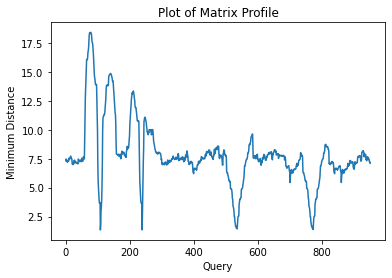

In [719]:
plt.title("Plot of Matrix Profile")
plt.plot(distance_profile_optimized)
plt.xlabel("Query")
plt.ylabel("Minimum Distance")

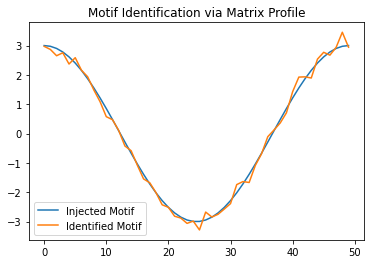

In [720]:
plt.title("Motif Identification via Matrix Profile")
plt.plot(motif_time_series_optimized, label = "Injected Motif")
plt.plot(A_optimized[ix_optimized[0]], label = "Identified Motif")
plt.legend()

As shown, our sliding-window matrix profile algorithm is able to identify the rough shape of the motif still!

## Discord Identification [20 points]

### Explain what a discord is in the context of time-series analysis and provide the math- ematical formulation. [10 points]

Reference [3]

1. Time series discords are subsequences of longer time series that are maximally different to the rest of the time series subsequences. 

Mathematical Formulation: 

- I will define a time series $T$ where $T = [t_1, t_2, ...., t_m ]$ consists of a set of $m$ real numbers. 

- We can define a subsequence $C$ of length $n$, where $n \leq m$, which is a contiguous slice from $T$. 

$C = [t_p, t_{p + 1}, ...., t_{p+n-1}]$ for $1 \leq p \leq m - n + 1$

- Given two subsequences, $C$ and $B$, we can define a function $D$ such that $D(B, C) = R$ where $R$ is a non-negative number and represents the distance between $B$ and $C$. 

- Non-Self Match: : Given a time series T, containing a subsequence C of length n beginning at position p and a matching subsequence B beginning at q, we say that B is a non-self match to C at distance of $D(B, C)$ if $|p - q| \geq n$

- Time Series Discord: Given a time series T, the subsequence A of length n beginning at position $i$ is said to be the discord of T if A has the largest distance to its nearest non-self match. $\forall C \in T$, let $M_C$ be any arbitrary non-self match of $C$ and $M_A$ be any arbitrary non-self match of $A$. We want the following to be true: 

$min(D(A, M_D)) > min(D(C, M_C))$


### Implement a discord identification algorithm and test it on a real-world time-series dataset. You may use datasets from the UCR Time Series Archive, Monash Forecasting Repository, Monash Time Series Forecasting Repository, Kaggle, or Machine Learning Mastery. [10 points]

To identify discords within a time series, this is the procedure I followed: 
1. First I generated the matrix profile as normally. 
2. A discord is the subsequence within the time series with the largest entry in the Matrix Profile. To recap, the Matrix Profile basically denotes, for each contiguous subsequence within the time series, the distance to its closest neighbor. Hence, we can see that the subsequence with the largest entry in the Matrix Profile has the largest distance to its nearest neighbor. This indicates that this subsequence is somewhat "anomalous" with respect to the entire time series. 

Note: Before testing on real-world data, I just wanted to play around with the discord identification algorithm and test it on synthetic data

In [721]:
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)

#To find a Discord, we need to find a maximum value in the Matrix Profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

Again, as I mentioned earlier, the discord is basically the subsequence within the time series with the largest entry in the Matrix Profile. The code above is responsible for finding this subsequence

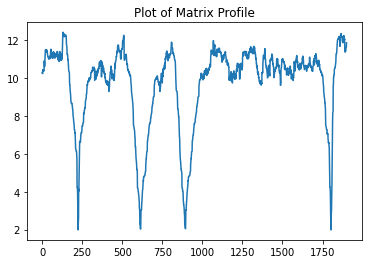

In [722]:
import matplotlib.pyplot as plt
plt.plot(distance_profile)
plt.title("Plot of Matrix Profile")
plt.show()

The above plot is a plot of the Matrix Profile

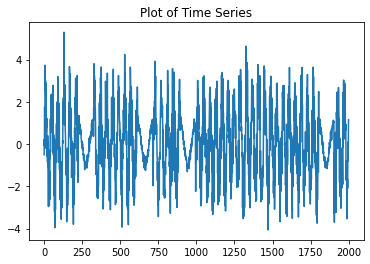

In [723]:
plt.plot(T)
plt.title("Plot of Time Series")
plt.show()

This is a plot of the time series

In [724]:
print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[130]
[1729.]
[12.41387848]


In [725]:
#Identify Discords within Synthetic Data for Fun 
A[ix]

array([[ 5.29254786,  2.23060014,  2.08763593,  2.04279987,  1.6378106 ,
         0.89134498,  2.80720147,  1.0570163 ,  0.75667489,  0.36605733,
         0.33776131, -0.76303503, -1.45143309, -0.35194742, -0.64759097,
        -0.66520215, -1.06050198, -1.52079409, -3.67744255, -2.64762595,
        -2.25799552, -1.81677304, -2.59187715, -0.19453583, -2.90111346,
        -1.14919823, -1.86600182, -1.69047281, -1.38040621, -0.46458086,
        -0.1633037 ,  0.86267002,  0.68921791,  0.89876475,  1.95474113,
         0.75340456,  3.66057679,  3.34702347,  1.66728975,  0.44906859,
         3.01960675,  3.32045458,  1.91340091,  0.27208966,  1.55434049,
         1.03678494,  1.69818491,  1.66140143, -0.49149911,  0.3100186 ,
        -1.58327069, -0.53814467, -0.11057079, -0.27215181, -1.55829219,
         0.12534584, -0.7348766 , -1.16923881, -2.22339818, -2.98163199,
        -0.34084841, -1.14158951, -3.79635372,  0.01734967, -2.86937305,
        -1.39867045, -0.29540991, -1.29803779, -0.6

### HOT SAX Algorithm

Reference [4]

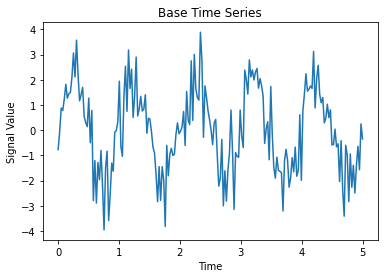

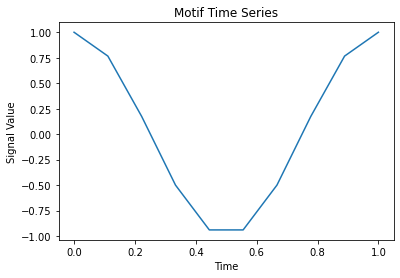

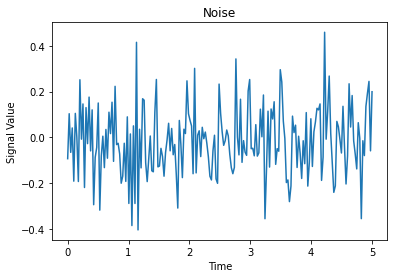

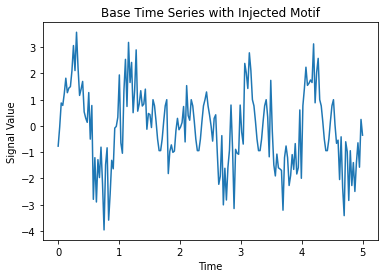

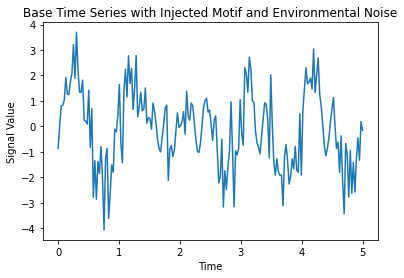

In [726]:
x_adjusted, motif_time_series = generateSyntheticData(2, 1, 5, 200, 10)
T = x_adjusted

In [727]:
#Define Gaussian Distribution
mean = np.mean(T) #mean of time series
var = np.var(T) #variance of time series
stdev = np.std(T) #standard deviation of time series

#Given a window, return a letter to represent that window. 
def discretize_window(window):
    u = np.mean(window)
    if u <= mean - 2.2 * stdev:
        return 'A'
    elif u <= mean - 2.0 * stdev:
        return 'B'
    elif u <= mean - 1.8 * stdev:
        return 'C'
    elif u <= mean - 1.6 * stdev:
        return 'D'
    elif u <= mean - 1.4 * stdev:
        return 'E'
    elif u <= mean - 1.2 * stdev:
        return 'F'
    elif u <= mean - 1.0 * stdev:
        return 'G'
    elif u <= mean - 0.8 * stdev:
        return 'H'
    elif u <= mean - 0.6 * stdev:
        return 'I'
    elif u <= mean - 0.4 * stdev:
        return 'J'
    elif u <= mean - 0.2 * stdev:
        return 'K'
    elif u <= mean:
        return 'L'
    elif u <= mean + 0.2 * stdev:
        return 'M'
    elif u <= mean + 0.4 * stdev:
        return 'N'
    elif u <= mean + 0.6 * stdev:
        return 'O'
    elif u <= mean + 0.8 * stdev:
        return 'P'
    elif u <= mean + 1.0 * stdev:
        return 'Q'
    elif u <= mean + 1.2 * stdev:
        return 'R'
    elif u <= mean + 1.4 * stdev:
        return 'S'
    elif u <= mean + 1.6 * stdev:
        return 'T'
    elif u <= mean + 1.8 * stdev:
        return 'U'
    elif u <= mean + 2.0 * stdev:
        return 'V'
    elif u <= mean + 2.2 * stdev:
        return 'W'
    else:
        return 'X'

#Partition a Time Series T into partitions of length P
def partition(T, P):
    num_partitions = len(T) // P
    partitions = np.split(T, num_partitions)
    return np.array(partitions)    

#Generate letter sequence for a time series. 
#T: original time series
#P: window of time series used to generate a letter
def generate_word(T, P):
    return np.apply_along_axis(discretize_window, axis = 1, arr = partition(T, P)).flatten()

#Given two words, calculate the edit distance between the two words. 
#A word is defined as a sequence of letters
#W1 and W2 are the two words
def edit_distance(W1, W2):
    if len(W2) == 0:
        return len(W1)

    if len(W1) == 0:
        return len(W2)
    
    if W1[0] == W2[0]:
        return edit_distance(W1[1:], W2[1:])
    
    return 1 + min(edit_distance(W1[1:], W2), edit_distance(W1, W2[1:]), edit_distance(W1[1:], W2[1:]))

#M is the length of the motif and we want each letter to be comprised of two points in our time series
M = 10
P = 2

W = generate_word(T, P) #Generate word for the time series 
L = M // P #letter subsequence length
A = generate_subsequences_set(W, L) #Generate subsequence of words

#Calculate matrix profile for the word subsequences
#The steps are roughly identical to the matrix profile algorithm that was previously implemented
def generate_SAX_matrix_profile(A):
    N, L = A.shape[0], A.shape[1]
    
    #Exclusion Zone
    exclusion = np.ceil(L / 2)
    distances = np.zeros(shape = (N,))
    indices = np.zeros(shape = (N,))
    
    #Iterate through each subseuence
    for i in range(N):
        #Define Exclusion Zone
        bound1 = max(0, i - exclusion)
        bound2 = min(i + exclusion, N - 1)
             
        #Calculate minimum distance(i.e. edit-distance) to other subsequences   
        min_distance = float('inf')
        min_index = None
        for j in range(N):
            if bound1 <= j and j <= bound2: continue 
            d = edit_distance(A[i], A[j])
            if d < min_distance:
                min_distance = d
                min_index = j
        
        distances[i] = min_distance
        indices[i] = min_index
    
    return distances, indices

In [728]:
#To find a motif, we need to find a minimum value in the Matrix Profile 
distance_profile, index_profile = generate_SAX_matrix_profile(A)
ix = np.where(distance_profile == np.min(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[13 14 15 21 22 28 29 35 36 37 42 43 44 46 47 51 52 61 62 63 64 81 82 83
 85 86 87 95]
[51. 52. 95. 81. 82. 46. 47. 85. 86. 87. 62. 63. 64. 28. 29. 13. 14. 83.
 42. 43. 44. 21. 22. 61. 35. 36. 37. 15.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2.]


Text(0, 0.5, 'Minimum Distance')

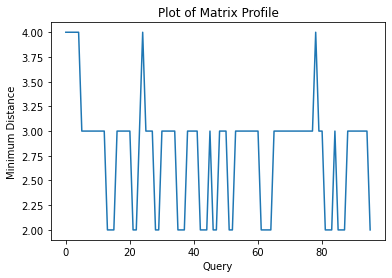

In [729]:
plt.title("Plot of Matrix Profile")
plt.plot(distance_profile)
plt.xlabel("Query")
plt.ylabel("Minimum Distance")

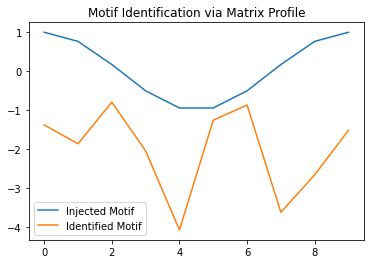

In [730]:
plt.title("Motif Identification via Matrix Profile")
plt.plot(motif_time_series, label = "Injected Motif")
plt.plot(T[ix[0] * P: ix[0] * P + M], label = "Identified Motif")
plt.legend()
plt.show()

In [731]:
#To find a Discord, we need to find a Maximum value in the distance profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[ 0  1  2  3  4 24 78]
[4. 5. 6. 7. 0. 2. 0.]
[4. 4. 4. 4. 4. 4. 4.]


When calculating the matrix profile for HOT SAX, it is the same steps I followed earlier for the regular matrix profile but this time, we are using letter sequences.

For the motif, the HOT SAX Algorithm doesn't return as effective results as the matrix profile algorithms I had implemented earlier. 

### Running Discord Identification on Real World Multivariate Dataset

The Multivariate Dataset I am using for this portion is "DailyDelhiClimateTrain.csv" which is a training dataset of temperature, humidity, wind speed, pressure for New Delhi, India from January 1st 2013 to January 1st 2017. 

Additionally, the "DailyDelhiClimateTest.csv" is a test dataset of temperature, humidity, wind speed, pressure for New Delhi, India from January 1st 2017 to April 24th 2017

Data Source: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/data

In [732]:
import pandas as pd

## Load a Multivariate Time Series Dataset
delhi_train = pd.read_csv("DailyDelhiClimateTrain.csv")
delhi_test = pd.read_csv("DailyDelhiClimateTest.csv")

#Convert the delhi training dataframe to matrix. We don't need to include the date in our matrix!
T = delhi_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].to_numpy()

#Set window to 12 days
M = 12

#Compute Matrix Profile
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)
distance_profile, index_profile

(array([36.02482202, 39.82550022, 38.36494455, ..., 41.48702351,
        40.19443415, 38.54110535]),
 array([  15., 1082., 1083., ...,    7.,  412.,  413.]))

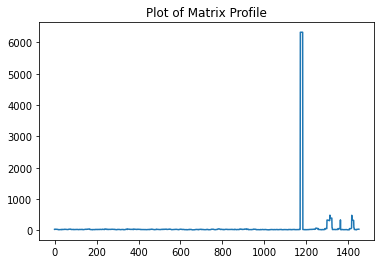

In [733]:
#Plot the Distance Profile
import matplotlib.pyplot as plt
plt.title("Plot of Matrix Profile")
plt.plot(distance_profile)
plt.show()

As shown by the figure, the subsequences with indices in the range 1170 to 1185 have the largest distance to its nearest neighbor. Hence, these clearly must be a discord!

In [734]:
#To find a Discord, we need to find a Maximum value in the Matrix Profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[1182]
[1362.]
[6327.31370352]


In [735]:
##Print Discord for Viewing
discords = A[ix]

In [736]:
### Get a discord for analysis
discord = discords[0]
discord_temperatures = np.sort(discord[:, 0].flatten())
discord_temperatures

array([25.93333333, 27.125     , 29.26666667, 29.57142857, 29.93333333,
       30.        , 30.57142857, 31.375     , 32.3125    , 32.3125    ,
       32.8125    , 33.3125    ])

I can understand why my algorithm marked this subsequence as a Discord. Just looking at the first column, which represents mean temperature, I can see that it ranges from roughly 25.9 degrees Celsius to roughly 33.3 degrees Celsius. This is a range of 7.4 degrees Celsius which corresponds to 45.32 degrees Fahrenheit. Being from India, having lived there for brief periods in my life, I know that this kind of temperature fluctuation is rare. Hence, I believe that my algorithm was able to correctly flag this subsequence as a discord

Our algorithm, as per the "ix" variable, was able to identify the subsequence with index 1182. As I mentioned before, this is within the range 1170 to 1185 and is the most apparent discord in our time series

# Neural Networks [40 points]

## 1. DNN Implementation [30 points]:

Implement a Deep Neural Network from scratch for a simple classification problem, excluding the backpropagation algorithm. [20 points]

Iteration 0, Cost: 0.694781667141648
Iteration 100, Cost: 0.6935377891068731
Iteration 200, Cost: 0.6931381017728845
Iteration 300, Cost: 0.6930089738381412
Iteration 400, Cost: 0.6929665975337955
Iteration 500, Cost: 0.6929520537376102
Iteration 600, Cost: 0.6929464438972147
Iteration 700, Cost: 0.6929437030429102
Iteration 800, Cost: 0.6929418840654435
Iteration 900, Cost: 0.6929403616943903


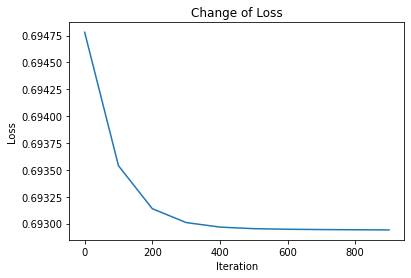

In [737]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1, self.b1, self.W2, self.b2 = self.initialize_parameters()

    def initialize_parameters(self):
        # Initialize weights and biases
        # TODO: Initialize W1, b1, W2, and b2
        
        #Shape of W1: (hidden_dim, input_dim)
        W1 = np.random.randn(self.hidden_dim, self.input_dim) * np.sqrt(1 / (self.input_dim + self.hidden_dim))
        
        #Shape of b1: (hidden_dim)
        b1 = np.random.randn(self.hidden_dim, 1) * np.sqrt(1 / (self.input_dim + self.hidden_dim))
        
        #Shape of W2: (output_dim, hidden_dim)
        W2 = np.random.randn(self.output_dim, self.hidden_dim) * np.sqrt(1 / (self.hidden_dim + self.output_dim))
        
        #Shape of b2: (output_dim)
        b2 = np.random.randn(self.output_dim, 1) * np.sqrt(1 / (self.hidden_dim + self.output_dim))
        
        return W1, b1, W2, b2

    def sigmoid(self, Z):
        # Sigmoid activation function
        # TODO: Implement sigmoid activation
        return 1 / (1 + np.exp(-1 * Z))

    def forward_propagation(self, X):
        # Forward propagation
        # TODO: Implement forward propagation
        
        Z1 = self.W1 @ X + self.b1
        A1 = self.sigmoid(Z1)
        
        Z2 = self.W2 @ A1 + self.b2
        A2 = self.sigmoid(Z2)
        
        return Z1, A1, Z2, A2

    def compute_cost(self, A2, Y):
        # Compute the cost
        # TODO: Implement cost computation
        
        #Clip values to avoid log(0) :) 
        epsilon = 1e-20
        A2_clipped = np.clip(A2, epsilon, 1 - epsilon)
        
        loss = - (Y * np.log(A2_clipped) + (1 - Y) * np.log(1 - A2_clipped))
        average_loss = np.mean(loss)
        
        return average_loss

    def backpropagation(self, X, Y, Z1, A1, Z2, A2):
        grads = {}
        m = X.shape[1]

        # Compute gradients
        dZ2 = A2 - Y
        dW2 = np.dot(dZ2, A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        dZ1 = np.dot(self.W2.T, dZ2) * (A1 * (1 - A1))
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        return grads

    def update_parameters(self, grads, learning_rate):
        # Update weights and biases
        self.W1 -= learning_rate * grads['dW1']
        self.b1 -= learning_rate * grads['db1']
        self.W2 -= learning_rate * grads['dW2']
        self.b2 -= learning_rate * grads['db2']


    def train(self, X, Y, learning_rate, num_iterations):
        iterations = []
        losses = []
        for i in range(num_iterations):
            Z1, A1, Z2, A2 = self.forward_propagation(X)
            cost = self.compute_cost(A2, Y)
            grads = self.backpropagation(X, Y, Z1, A1, Z2, A2)
            self.update_parameters(grads, learning_rate)
            if i % 100 == 0:
                print(f"Iteration {i}, Cost: {cost}")
                iterations.append(i)
                losses.append(cost)
        
        return iterations, losses

if __name__ == "__main__":
    # Generate synthetic data
    X = np.random.rand(2, 500)
    Y = np.random.randint(0, 2, size=(1, 500))

    # Initialize the neural network
    nn = SimpleNN(2, 4, 1)

    # Train the neural network
    iterations, losses = nn.train(X, Y, learning_rate=0.01, num_iterations=1000)
    
    #Plot the losses
    plt.title("Change of Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(iterations, losses)

## 2. CNN Implementation [10 points]:

Complete the convolution code below. [10 points]

In [738]:
def convolution2D(image, kernel):
    # Get the dimensions of the image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculate the output dimensions
    output_height = image_height - kernel_height + 1
    #TODO: Compute the output height
    output_width = image_width - kernel_width + 1
    #TODO: Compute the output width
    
    # Initialize the output feature map
    output = np.zeros((output_height, output_width))
    
    # Perform 2D convolution
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest (ROI) from the image
            #todo: Extract the region of interest (ROI) from the image
            
            ROI = image[i:i+kernel_height, j:j+kernel_width]
            
            # Compute the element-wise multiplication and sum
            #todo: Compute the element-wise multiplication and sum
            output[i][j] = np.sum(ROI * kernel)
    
    return output

# Example usage:
if __name__ == "__main__":
    # Create a sample grayscale image (8x8 pixels)
    image = np.array([[1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1]])
    
    # Create a sample kernel (3x3)
    kernel = np.array([[1, 0, -1],
                       [1, 0, -1],
                       [1, 0, -1]])
    
    # Perform 2D convolution
    result = convolution2D(image, kernel)
    print(result)

[[-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]]


# Integrated Application [Optional, 10 Bonus Points]

### 1. Implement an end-to-end pipeline for automated time series classification that inte- grates motif and discord detection with deep learning. [10 Bonus Points]

Note: The end-to-end pipeline I have implemented here is a proof of concept. Although I have not achieved state-of-the-art results, it outlines a general approach that I would follow in a practical scenario

Load a multivariate time series dataset (e.g., human activity recognition data).

The Multivariate Dataset I am using for this portion is "DailyDelhiClimateTrain.csv" which is a training dataset of temperature, humidity, wind speed, pressure for New Delhi, India from January 1st 2013 to January 1st 2017. 

Additionally, the "DailyDelhiClimateTest.csv" is a test dataset of temperature, humidity, wind speed, pressure for New Delhi, India from January 1st 2017 to April 24th 2017

Data Source: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/data

In [739]:
import pandas as pd

## Load a Multivariate Time Series Dataset
delhi_train = pd.read_csv("DailyDelhiClimateTrain.csv") #training data
delhi_test = pd.read_csv("DailyDelhiClimateTest.csv") #test data

In [740]:
#Print the training dataframe
delhi_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [741]:
#Print the test data frame
delhi_test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


Use the matrix profile and HOT SAX algorithms to identify motifs and discords in the time series data. These can help discover salient patterns and anomalies.

In [742]:
## Use the matrix profile and HOT SAX algorithms to identify motifs and discords in the time series data. These can help discover salient patterns and anomalies.
## This will be done on the training data

#Convert the delhi training dataframe to matrix. We don't need to include the date in our matrix!
T = delhi_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].to_numpy()

#Set window to 12 days
M = 12

#Compute Matrix Profile that will be used to find motifs and discords
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)
distance_profile, index_profile

(array([36.02482202, 39.82550022, 38.36494455, ..., 41.48702351,
        40.19443415, 38.54110535]),
 array([  15., 1082., 1083., ...,    7.,  412.,  413.]))

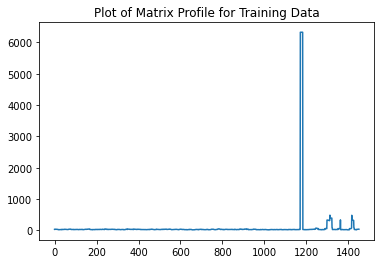

In [743]:
#Plot Distance Profile
import matplotlib.pyplot as plt
plt.title("Plot of Matrix Profile for Training Data")
plt.plot(distance_profile)
plt.show()

In [744]:
#To find a Discord, we need to find a Maximum value in the Matrix Profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[1182]
[1362.]
[6327.31370352]


In [745]:
##Print Discord for Viewing
discords = A[ix]

In [746]:
### Get a discord for analysis
discord = discords[0]
discord_temperatures = np.sort(discord[:, 0].flatten())
discord_temperatures

array([25.93333333, 27.125     , 29.26666667, 29.57142857, 29.93333333,
       30.        , 30.57142857, 31.375     , 32.3125    , 32.3125    ,
       32.8125    , 33.3125    ])

I can understand why my algorithm marked this subsequence as a Discord. Just looking at the first column, which represents mean temperature, I can see that it ranges from roughly 25.9 degrees Celsius to roughly 33.3 degrees Celsius. This is a range of 7.4 degrees Celsius which corresponds to 45.32 degrees Fahrenheit. Being from India, having lived there for brief periods in my life, I know that this kind of temperature fluctuation is rare. Hence, I believe that my algorithm was able to correctly flag this subsequence as a discord

Based on this Matrix Profile, there seems to one clear anomaly for the subsequence at index 1182. Now, let's take a look at the remaining portion of the Matrix Profile to see how the other values are distributed. 

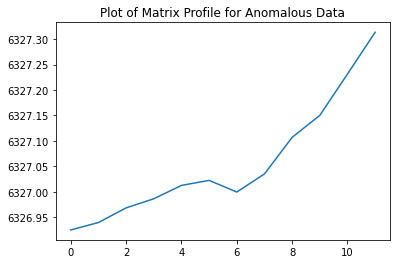

In [747]:
import matplotlib.pyplot as plt
plt.title("Plot of Matrix Profile for Anomalous Data")
plt.plot(distance_profile[1171: 1183])
plt.show()

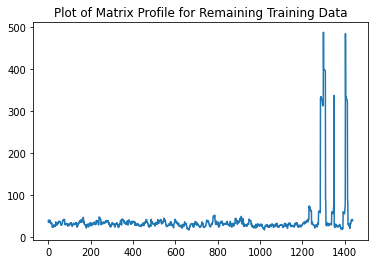

In [748]:
import matplotlib.pyplot as plt
plt.title("Plot of Matrix Profile for Remaining Training Data")
plt.plot(np.hstack((distance_profile[:1171], distance_profile[1183:])))
plt.show()

### Extract motif and discord segments and use them as additional input features for a neural network, along with statistical features like mean, variance, autocorrelation, etc.

It must also be said that, among the remaining data, there is still some rather anomalous data. Hence, from this point on, I decided that the best option was to take the distances, fit them to a Gaussian Distribution and compute z-scores. Anything above a 2 z-score or below a -2 z-score would be considered anomalous. A z-score within the range [-2, 2] would be considered a normal time series subsequence. 

In [749]:
#Let's put the distance profiles on a distribution in order to calculate labels. 
#If the absolute value of the z score is < 2, then we will say that the subsequence is "anomalous"
u = np.mean(distance_profile)
std = np.std(distance_profile)
z_scores = np.array([(x - u) / std for x in distance_profile])
labels = np.array([1 if np.abs(z_score) < 2 else 0 for z_score in z_scores])

Calculate the Z-Scores of the distances. If the Z_score is above 2 or below -2, we will say that the subsequence of the time series is an anomaly. Else, we will say that the subsequence of the time series is "normal" and not a subsequence. 

In [750]:
### Define a 1D Convolutional Neural Network via PyTorch
class CNN1D(torch.nn.Module):
    def __init__(self, input_length, in_channels, num_filters, kernel_size, pool_kernel_size, output_fc_1, output_fc_2):
        super().__init__()
        
        #Define Structure of CNN
        self.L = input_length
        self.K = kernel_size
        self.P = pool_kernel_size
        self.Cin = in_channels
        self.Cout = num_filters
        
        self.output_fc_1 = output_fc_1
        self.output_fc_2 = output_fc_2
        
        #1D Convolution
        self.conv = torch.nn.Conv1d(in_channels = self.Cin, out_channels = self.Cout, kernel_size = self.K)
        
        #Pooling Layer
        self.pool = torch.nn.MaxPool1d(self.P)
        
        conv_L = self.L - self.K + 1

        # Fully connected layer
        self.fc1 = torch.nn.Linear((int(0.5 * (conv_L - self.P)) + 1) * self.Cout, self.output_fc_1)
        self.fc2 = torch.nn.Linear(self.output_fc_1, self.output_fc_2)
        
        #Sigmoid Function
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input):
        #Start with Convolution and Pooling Layers
        x = self.conv(input)        
        x = self.pool(x)
        
        #Run through fully connected layers
        x = torch.flatten(x, 1)                
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        
        #Run through sigmoid
        x = self.sigmoid(x)      
        return torch.flatten(x)

Here is how I am defining my 1D Convolutional Neural Network. I have 1 1D Convolution Layer, followed by a Max Pooling Layer, followed by 2 fully connected layers, and completed with a Sigmoid function. Each fully connected layer has a ReLU Activation Function. 

In [751]:
def train(model, input, labels, epochs):
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
    loss_fn = torch.nn.BCELoss(reduction = 'mean')
    for epoch in range(epochs):        
        #Zero out gradients
        optimizer.zero_grad()
        
        #Run Forward Pass, Backward Propagation, then update weights
        outputs = model(input)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #Pring Loss        
        print(f'[Epoch {epoch + 1}] loss: {loss.item():.3f}')

Define a function to train the Convolutional Neural Network

In [752]:
shape = A.shape
model = CNN1D(shape[1], shape[2], 3, 3, 2, 6, 1).to(torch.float32)

A = torch.permute(torch.from_numpy(A), (0, 2, 1)).to(torch.float32)
labels = torch.from_numpy(labels).to(torch.float32)

print(A.size())
print(labels.size())

torch.Size([1451, 4, 12])
torch.Size([1451])


The input to the CNN will be the subsequences from the time series. The labels, as I demonstrated earlier, will be the "labels" derived for the training data samples. 

In [753]:
train(model, A, labels, 25)

[Epoch 1] loss: 0.760
[Epoch 2] loss: 0.760
[Epoch 3] loss: 0.760
[Epoch 4] loss: 0.760
[Epoch 5] loss: 0.760
[Epoch 6] loss: 0.760
[Epoch 7] loss: 0.760
[Epoch 8] loss: 0.760
[Epoch 9] loss: 0.760
[Epoch 10] loss: 0.760
[Epoch 11] loss: 0.760
[Epoch 12] loss: 0.760
[Epoch 13] loss: 0.760
[Epoch 14] loss: 0.760
[Epoch 15] loss: 0.760
[Epoch 16] loss: 0.760
[Epoch 17] loss: 0.760
[Epoch 18] loss: 0.760
[Epoch 19] loss: 0.760
[Epoch 20] loss: 0.760
[Epoch 21] loss: 0.760
[Epoch 22] loss: 0.760
[Epoch 23] loss: 0.760
[Epoch 24] loss: 0.760
[Epoch 25] loss: 0.760


Train the CNN model and report losses!

In [754]:
T2 = delhi_test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].to_numpy()

#Set window to 12 days
M = 12
A = generate_subsequences_set(T, M)
A2 = generate_subsequences_set(T2, M)

#For the test data set, we need to calculate distances to the training data subsequences. 
distance_profile = np.zeros(shape = len(A2,))
for index in range(len(A2)):
    norms = np.linalg.norm(A2[index] - A, axis = (1,2)).flatten()
    distance_profile[index] = np.min(norms)

Generate subsequences for test data and compute distances to the training data subsequences. The subsequences for the test data are the inputs for the test data. The expected labels for the test data are the labels derived from the z scores of the distances to the training subsequences. If the absolute value of the z score is > 2, we say that the test data is an anomaly. Else, the test data point is "normal"(a.k.a not an anomaly)

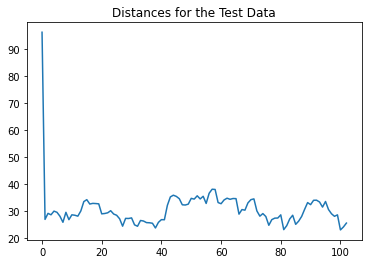

In [755]:
#Plot distance profile
import matplotlib.pyplot as plt
plt.title("Distances for the Test Data")
plt.plot(distance_profile)
plt.show()

Plot the Matrix Profile derived for the test data points

In [756]:
#Let's put the Matrix Profile on a distribution in order to calculate labels
#If the absolute value of the z score is < 2, then we will say that the subsequence is "anomalous"
u = np.mean(distance_profile)
std = np.std(distance_profile)
z_scores = np.array([(x - u) / std for x in distance_profile])
labels = np.array([1 if np.abs(z_score) < 2 else 0 for z_score in z_scores])

Calculate expected labels for the test data

In [757]:
A2 = torch.permute(torch.from_numpy(A2), (0, 2, 1)).to(torch.float32)
labels = torch.from_numpy(labels).to(torch.float32)

Prepare Data prior to feeding it to the CNN

In [758]:
correct = 0
total = 0
loss_fn = torch.nn.BCELoss(reduction = 'mean') #Binary Cross Entropy Loss Function

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    # calculate outputs by running input through the network
    outputs = model(A2)
    predictions = (outputs >= 0.5).int().to(torch.float32)
    loss = loss_fn(outputs, labels)
    total += labels.size(0)
    correct += (predictions == labels).sum().item()
    print(f"Binary Cross Entropy Loss: {loss}")

print(f'Accuracy of the Model on the {total} Test Subsequences: {100 * correct // total} %')

Binary Cross Entropy Loss: 0.08008752018213272
Accuracy of the Model on the 103 Test Subsequences: 99 %


Compute loss on the test data and accuracy! Clearly, the loss achieved here was 0.08 and we achieved a very high prediction accuracy. This showed that using the z-score methodology that I outlined earlier to label the data as well as using time series subsequences as inputs to the CNN was effective in making a classifier to classify time series subsequences as anomalous or "normal"(i.e. not anomalous). 

# References
[1] Mueen, Abdullah et al. “Exact Discovery of Time Series Motifs.” Proceedings of the ... SIAM International Conference on Data Mining. SIAM International Conference on Data Mining vol. 2009 (2009): 473-484. doi:10.1137/1.9781611972795.41

[2] C. -C. M. Yeh et al., "Matrix Profile I: All Pairs Similarity Joins for Time Series: A Unifying View That Includes Motifs, Discords and Shapelets," 2016 IEEE 16th International Conference on Data Mining (ICDM), Barcelona, Spain, 2016, pp. 1317-1322, doi: 10.1109/ICDM.2016.0179.

[3] Keogh, E., Lin, J., Lee, SH. et al. Finding the most unusual time series subsequence: algorithms and applications. Knowl Inf Syst 11, 1–27 (2007). https://doi.org/10.1007/s10115-006-0034-6

[4] E. Keogh, J. Lin and A. Fu, "HOT SAX: efficiently finding the most unusual time series subsequence," Fifth IEEE International Conference on Data Mining (ICDM'05), Houston, TX, USA, 2005, pp. 8 pp.-, doi: 10.1109/ICDM.2005.79.

[5] https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/data